<div align="center">
    <h1> 15688 Practical Data Science Final Project (2018 Spring)</h1>
    <h2>Prediction on Whether a Hit Song Has the Potential to Become a Super Hit </h2>
    <h5>Amy Huang, Chia-Hua Lee, Wei-Kung Wang</h5>
</div>


## Motivation & Project Description

Billboard Hot 100 is one of the most credible record charts in the music industry in the United States. <a href = "https://www.billboard.com/biz/articles/news/1179201/business-matters-75000-albums-released-in-us-in-2010-down-22-from-2009"> While there are more than 75,000 albums released in the U.S. per year,</a> only a few songs can stay on the board for a long period of time. We are curious about how these songs differ from others. Thus, the goal of this project is to uncover the secrets behind popular songs.

More specifically, we would like to identify songs that pass our 20-week on-board threshold on the Billboard HOT 100 record chart. Concretely, our project aims to build a model that can correctly predict whether ***a Hit song*** will become ***a Super Hit*** based on the song's audio features and metadata extracted from Spotify. Songs that are considered as Hits are the ones that entered the Billboard HOT100 record chart (meaning that the song was once on the Billboard for at least one week); Songs that are labeled as Super Hits are the ones that remained on Billboard HOT100 for more than 20 weeks. The rationale of choosing 20 weeks to be the threshold for Super Hit will be further explained in the Exploratory Data Analysis section.

<img src="https://drive.google.com/uc?export=view&id=186e2kdqqgVDwMAsNIw1EZqL3yzXBV3FX" style="width: 50%; height: 50%"/ >

We will cover the following topics in this project:
- [Data Collection](#Data-Collection)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Data Processing](#Data-Processing)
- [Model Tuning and Debugging](#Model-Tuning-and-Debugging)
- [Model Performance and Conclusion](#Model-Performance-and-Conclusion)
- [References and Resources](#References)
- [Appendix](#Appendix)

## Data Collection

In our project, data are collected from two sources, Spotify and Billboard TOP100. Song rankings on Billboard can go back as far as 1958-8-9. However, because there might be huge differences with respect to music tastes among different time periods, we have selected to use billboard rankings from 1990 to 2018 rather than the entire data to reduce the dispersion of taste in different times. 

Steps we took to get our data:

__1. Use <a href="https://github.com/guoguo12/billboard-charts">***billboard libaray***</a> to retrieve weekly rankings from billboard.__

Data collected: rank, song_name, singer, date, weeks (accumulative number of weeks so far) 

__2. Use the song_name and singer to collect more metadata (with Spotify API)__ 

Data collected: spotifyId, popularity, album name, release date...

__3. Use the spotifyID to get audio features (also with Spotify API)__

Data collected: acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, valence

Note: The code for data collection can be found in the appendix

<a href="https://beta.developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/">*** _Spotify Audio Features_***</a>

Below are the definitions for the audio features:

1. tempo — Beats per minute. The tempo of the song.

2. energy — The energy of a song — the higher the value, the more energetic the song

3. danceabiliy — The higher the value, the easier it is to dance to this song.

4. loudness — The higher the value, the louder the song.

5. valence — The higher the value, the more positive mood for the song.

6. acousticness — The higher the value the more acoustic the song is.

7. duration_ms — Length of a song in milliseconds.

8. instrumentalness — The higher the value, the song contains more instrument content, less vocal content.

9. key (categorical) — The key of the song.  Can be mapped to pitches using standard  <a href="https://en.wikipedia.org/wiki/Pitch_class">***Pitch Class notation.***</a> 

10. liveness — Ther higher the value, the song is more likely to be a live performance.

11. mode (categorical) — Indicates the modality (major or minor) of a track.  Major, mode = 1; minor, mode = 0

12. speechiness — The higher the value, spoken words appear more often.

In [66]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
plt.style.use('ggplot')  # prettier plots

### Billboard HOT 100

We retrieved data on the Billboard HOT 100 from 1990-01-06 to 2018-04-21.<br>
The total number of data is 147,700; The whole dataset contains 10,446 unique songs.

In [52]:
# This file contains data on Billboard HOT 100, from 1990-01-06 to 2018-04-21,
# the data collection process and more details can be found in appendix
df = pd.read_csv('data/billboard_19902018.csv')
print(df.shape)
print('# of unique tracks:', df[['song_name', 'singer']].drop_duplicates().shape[0])
df.head()

(147700, 5)
# of unique tracks: 10446


,rank,song_name,singer,date,weeks
0,1,Nice For What,Drake,2018-04-21,1
1,2,God's Plan,Drake,2018-04-21,12
2,3,Meant To Be,Bebe Rexha,2018-04-21,25
3,4,Psycho,Post Malone,2018-04-21,7
4,5,Look Alive,BlocBoy JB,2018-04-21,9


### Spotify API (SpotifyID and Audio Features)

To enrich the features of the songs, we decide to colloect audio features for them. This can be done by making queries to the Spotify Web API. But not all the matchings between Billboard and Spotify data are successful. More details can be found in the Appendix. We successfully acquire the spotifyId and audio features of 9,120 tracks.

In [53]:
# This file contains the unique tracks and their audio features
# the data collection process and more details can be found in appendix
spotify_feature = pd.read_csv("data/19902018_Billboard_audio_feature.csv")
print(spotify_feature.shape)
spotify_feature.head()

(9120, 25)


,album_id,artists_id,artists_name,b_artist,b_trackName,popularity,releaseDate,spotifyId,trackName,track_number,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,3pLdWdkj83EYfDN6H2N8MR,"['5IcR3N7QB1j6KBL8eImZ8m', '17lzZA2AlOHwCwFALH...","['ScHoolboy Q', '2 Chainz', 'Saudi']",ScHoolboy Q,X,83,2018-02-09,4LmAnpjlhWTahvRkYR8xJa,X (with 2 Chainz & Saudi),3,...,0.468,0.00000,2,0.2600,-8.480,1,0.2740,131.026,4,0.360
1,5lkNnHVlnCCCV304t89wOH,"['0jnsk9HBra6NMjO2oANoPY', '6d47Z08T4snK50HgTE...","['Flo Rida', 'Sage The Gemini', 'Lookas']",Flo Rida,G.D.F.R.,71,2015-04-07,26rdOwwjC2UnweK3xeS58u,GDFR (feat. Sage The Gemini & Lookas),6,...,0.827,0.00534,5,0.0650,-4.036,1,0.0734,145.889,4,0.690
2,5Hs43ta4vAYKRRRR7DKjt9,"['1gPhS1zisyXr5dHTYZyiMe', '2iojnBLj0qIMiKPvVh...","['Kevin Gates', 'Trey Songz', 'Ty Dolla $ign',...",Kevin Gates,Jam,59,2016-01-29,2IAaBzOLUtr2hqcwOItFWJ,"Jam (feat. Trey Songz, Ty Dolla $ign and Jamie...",16,...,0.633,0.00000,2,0.1440,-7.732,1,0.1130,120.011,4,0.549
3,4I3EcXD4e3KcEoDJfFEZ5b,"['1URnnhqYAYcrqrcwql10ft', '0iEtIxbK0KxaSlF7G4...","['21 Savage', 'Metro Boomin', 'Future']",21 Savage,X,80,2016-07-15,6fwdbPMwP1zVStm8FybmkO,X (feat. Future),3,...,0.413,0.00133,1,0.1010,-9.810,1,0.3960,149.004,4,0.111
4,3U1X1wd3lX7EteWYhS2hpT,"['6TIYQ3jFPwQSRmorSezPxX', '3NPpFNZtSTHheNBaWC...","['Machine Gun Kelly', 'X Ambassadors', 'Bebe R...","Machine Gun Kelly,",Home,83,2017-11-18,0OI7AFifLSoGzpb8bdBLLV,"Home (with Machine Gun Kelly, X Ambassadors & ...",1,...,0.718,0.00000,3,0.0537,-5.232,0,0.2130,82.034,4,0.216


In [54]:
# merge spotifyId and meta data with Billboard rank data
df = pd.read_csv('data/billboard_19902018.csv')
data = df.merge(spotify_feature, left_on=['singer', 'song_name'], right_on=['b_artist','b_trackName'], how='inner')

# find out the maximum stay of each track
max_idx = df.groupby(['singer', 'song_name'])['weeks'].transform(max) == df['weeks']
data_max_week = df[max_idx][['song_name', 'singer', 'weeks']]

# create a new column 'max_week'
data_max_week = data_max_week.rename(index=str, columns={'weeks':'max_week'})
data_ = data.merge(data_max_week, how = 'inner')
data_["superhit"] = np.where(data_["max_week"] > 20, 1, 0)
data_.head()

,rank,song_name,singer,date,weeks,album_id,artists_id,artists_name,b_artist,b_trackName,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,max_week,superhit
0,1,Nice For What,Drake,2018-04-21,1,1ZGxGu4fMROqmZsFSoepeE,['3TVXtAsR1Inumwj472S9r4'],['Drake'],Drake,Nice For What,...,8,0.114,-6.471,1,0.0736,93.35,4,0.792,1,0
1,2,God's Plan,Drake,2018-04-21,12,1r0DOIO0iC0bGpMtWRFdde,['3TVXtAsR1Inumwj472S9r4'],['Drake'],Drake,God's Plan,...,7,0.498,-9.488,1,0.0963,77.17,4,0.344,12,0
2,1,God's Plan,Drake,2018-04-14,11,1r0DOIO0iC0bGpMtWRFdde,['3TVXtAsR1Inumwj472S9r4'],['Drake'],Drake,God's Plan,...,7,0.498,-9.488,1,0.0963,77.17,4,0.344,12,0
3,1,God's Plan,Drake,2018-04-07,10,1r0DOIO0iC0bGpMtWRFdde,['3TVXtAsR1Inumwj472S9r4'],['Drake'],Drake,God's Plan,...,7,0.498,-9.488,1,0.0963,77.17,4,0.344,12,0
4,1,God's Plan,Drake,2018-03-31,9,1r0DOIO0iC0bGpMtWRFdde,['3TVXtAsR1Inumwj472S9r4'],['Drake'],Drake,God's Plan,...,7,0.498,-9.488,1,0.0963,77.17,4,0.344,12,0


## Exploratory Data Analysis

### Distribution of songs' maximum stays on Billboard HOT 100
In this section, we would like to figure out the distribution of the maximum weeks that songs can remain on Billboard.

In [55]:
# preserve only the maximum weeks on board
df_ = df.loc[:,["song_name","singer","weeks"]].groupby(["singer","song_name"]).max()
df_ = df_.reset_index()

In [56]:
df_.weeks.describe()

count    10439.000000
mean        14.273973
std         10.119862
min          1.000000
25%          5.000000
50%         15.000000
75%         20.000000
max         87.000000
Name: weeks, dtype: float64

The following plot is the distribution of tracks' maximum stay on Billboard.  We can see that there are two peaks: 1 week and 20 weeks.  We can see that a lot of songs were only able to stay on the board for one week; which is not that surprising; What really intrigued us is the peak at 20 weeks and the steep drop afterwards. After a litter research, we found that this is due to a Billboard rule: Songs need to be in the top 50 after being on the board for 20 weeks; otherwise, they will be dropped from the board.  <a href="https://www.billboard.com/articles/columns/chart-beat/6770427/adele-tops-hot-100-fourth-week-justin-bieber-alessia-cara">***(reference)***</a>

In [57]:
distribution=df_["weeks"].value_counts().reset_index().sort_values('weeks', ascending=False).reset_index(drop=True)

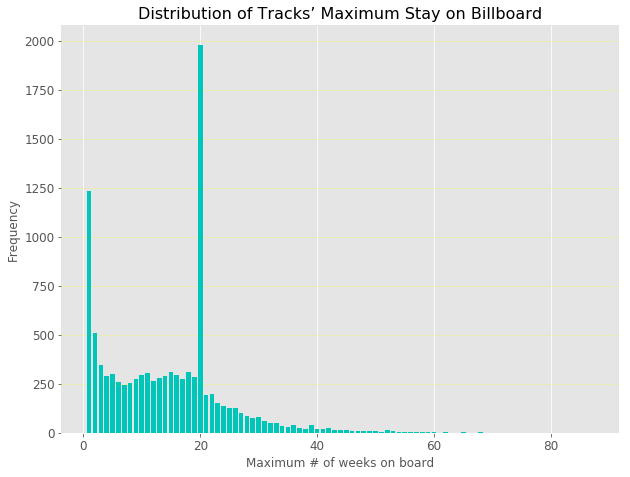

In [58]:
fig, ax = plt.subplots(figsize=(10,7.5))
plt.bar(distribution.loc[:,"index"],distribution.loc[:,"weeks"], color="#00c5b9") 
ax.yaxis.grid("on",linewidth=1,linestyle="--",color="yellow", alpha=0.3)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
plt.xticks(fontsize=12)
plt.title('Distribution of Tracks’ Maximum Stay on Billboard', fontsize = 16)
plt.xlabel('Maximum # of weeks on board')
plt.ylabel('Frequency')
plt.yticks(fontsize=12)
plt.show()

Under the 20-week rule, We think that a song which can stay on the board for more than 20 weeks is really a Super Hit! And we are interested in figuring out why a song would become super popular. Therefore, we decided to label songs' with a maximum stay on board for more than 20 weeks as __Super Hits__ and try to build classifiers to differentiate Super Hits from Hits. <br>

### Spotify Audio Features

We decide to have a closer look of the collected audio features from Spotify.<br>

There is an interesting trend of music taste in __duration__ and __loudness__.  The durations are decreasing while the loudness are increasing with time for both Hits and Super Hits.<br>

Also, it might be possible to differentiate Super Hits from Hits using __danceability__, __tempo__ and __speechiness__; especially when looking at a specific time period:
In the recent 10 years, danceability seems to be higher for Super Hits compared to Hits. <br>
In recent years, Super Hits tend to have higher valence; which means more positive (e.g. happy, cheerful, euphoric) tracks are more popular. <br>

Note that plots without a y-axis label mean that the values range from 0 to 1, representing the degree. For example, if the danceability of a song is closer to 1; it's more suitable for dancing. <brt

In [59]:
def plot_y_average(df, y_ls, labels, compare, n_row, n_col):
    from scipy.interpolate import spline
    from matplotlib.ticker import FormatStrFormatter
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    fig, axs = plt.subplots(nrows = n_row, ncols = n_col, sharex=True, figsize=(60,50))
    y_idx = 0
    for i in range(n_row):
        for j in range(n_col):
            y = y_ls[y_idx]
            df_current = df.groupby(['year', compare])[y].mean().unstack(level=-1, fill_value=None).reindex()
            df_current = df_current.reset_index()
            xnew = np.linspace(df_current['year'].min(),df_current['year'].max(),100)
            smooth_nothit = spline(df_current['year'],df_current.iloc[:,1],xnew)
            smooth_superhit = spline(df_current['year'],df_current.iloc[:,2],xnew)
            ax = axs[i][j]
            ax.plot(xnew, smooth_nothit, label="Hit",color = "#00c5b9",linewidth=4)
            ax.plot(xnew, smooth_superhit, label="Super Hit",color="#f05768",linewidth=4)
#             ax.spines["top"].set_visible(False)    
#             ax.spines["bottom"].set_visible(False)    
#             ax.spines["right"].set_visible(False)    
#             ax.spines["left"].set_visible(False)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.tick_params(labelsize=40)
            ax.set_title(y_ls[y_idx], size = 40)
            ax.set_ylabel(labels[y_idx], size = 40)
            ax.yaxis.grid("on",linewidth=1,linestyle="--",color="grey", alpha=0.3)
            y_idx += 1
    plt.tight_layout()
    plt.legend(fontsize = 36, loc = 3)
    plt.show()
    pass

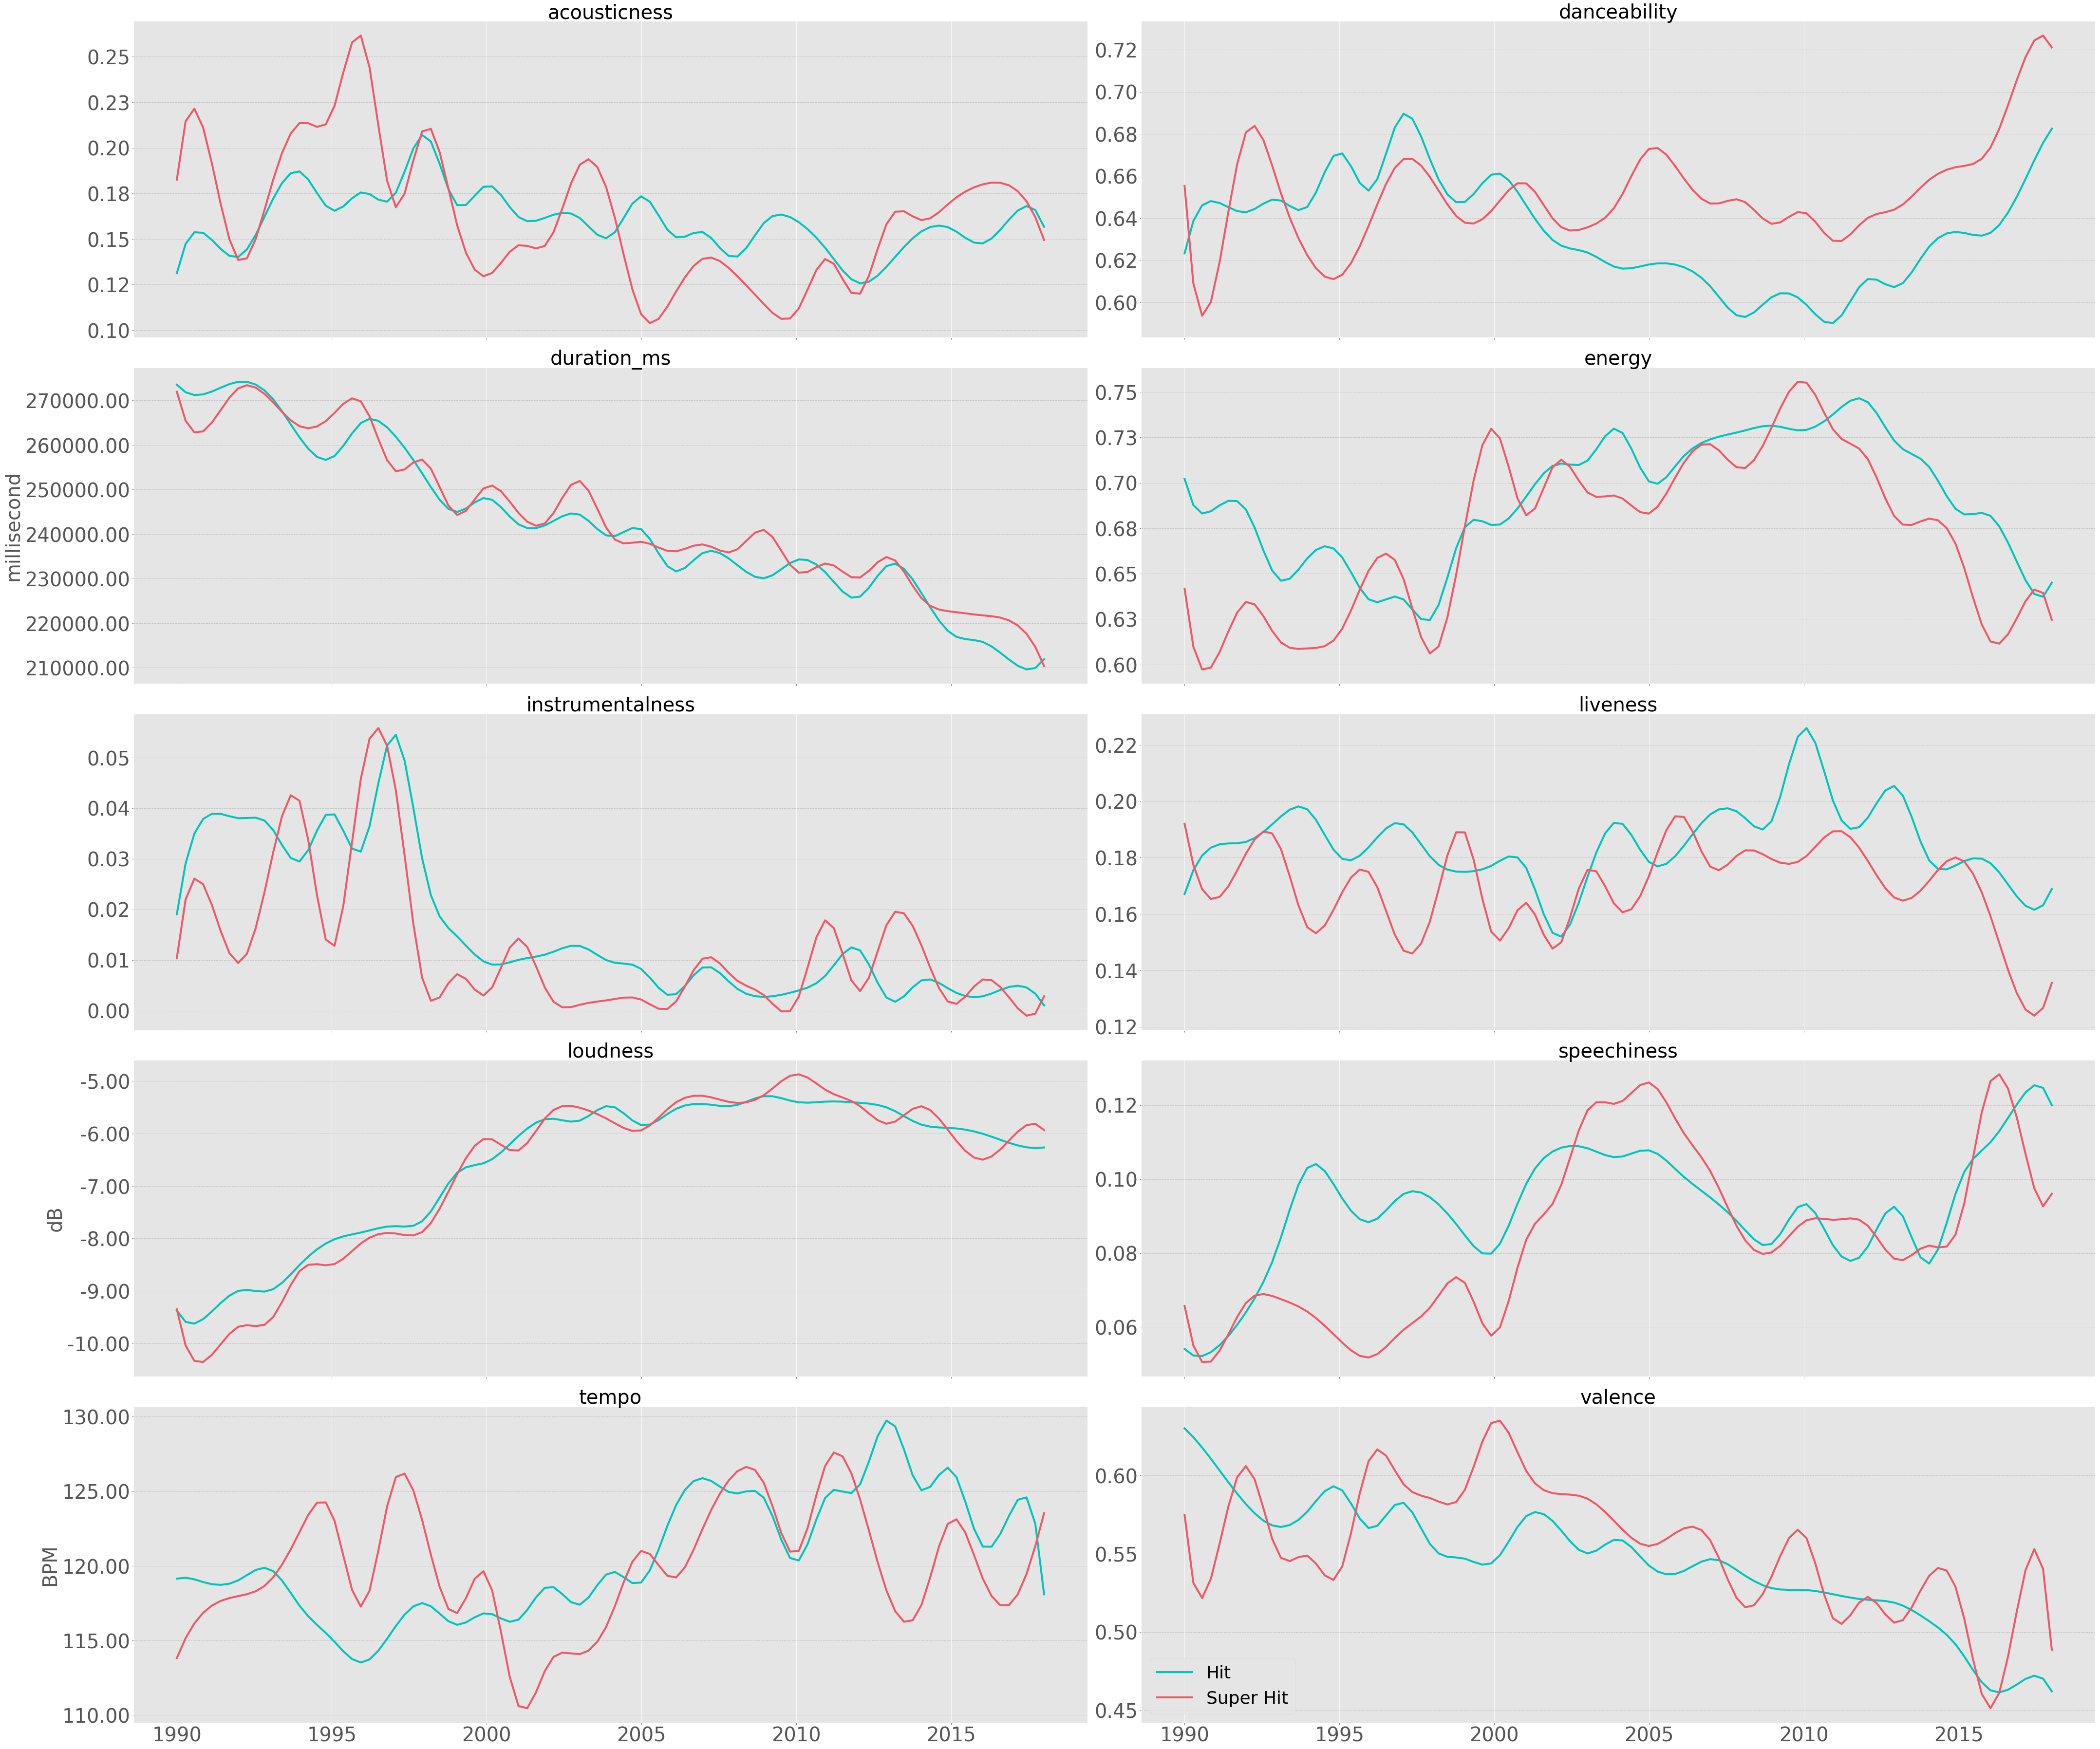

In [60]:
feature_ls = ['acousticness',
              'danceability',
              'duration_ms',
              'energy',
              'instrumentalness',
              'liveness',
              'loudness',
              'speechiness',
              'tempo',
              'valence']
y_labels = ['','', 'millisecond','','','','dB','','BPM','' ]
plot_y_average(data_, feature_ls, y_labels,'superhit', n_row = 5, n_col = 2)

### Rank difference within a month

Besides the features that we got from Spotify API, the change of ranks of songs themselves might also reveal information about Super Hits. Let's take a look:

In [61]:
data_diff = data_[['singer', 'song_name', 'max_week', 'weeks', 'superhit', 'date', 'rank']]
data_merged = data_diff[data_diff['weeks'] == 4].merge(data_diff[data_diff['weeks'] == 1],
                                                       left_on = ['singer', 'song_name', 'max_week', 'superhit'],
                                                       right_on = ['singer', 'song_name', 'max_week', 'superhit'])
data_merged.head()

,singer,song_name,max_week,weeks_x,superhit,date_x,rank_x,weeks_y,date_y,rank_y
0,Drake,God's Plan,12,4,0,2018-02-24,1,1,2018-02-03,1
1,Bebe Rexha,Meant To Be,25,4,1,2017-12-02,53,1,2017-11-11,61
2,Post Malone,Psycho,7,4,0,2018-03-31,5,1,2018-03-10,2
3,BlocBoy JB,Look Alive,9,4,0,2018-03-17,7,1,2018-02-24,6
4,Zedd,The Middle,11,4,0,2018-03-03,13,1,2018-02-10,23


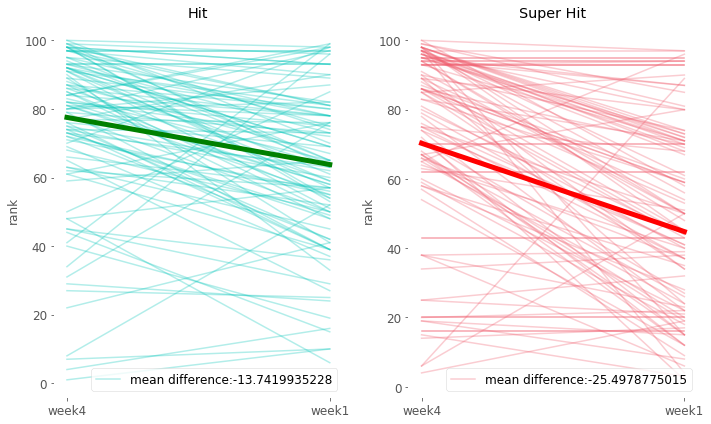

In [62]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,6)) #sharey=True, 
hit_flag = [0,1]
labels = ['Hit', 'Super Hit']
colors = ['#00c5b9', '#f05768']
line_colors = ['green', 'red']

for idx in hit_flag:
    ax = axs[idx]
    data_superhit = data_merged[data_merged["superhit"]==idx]
    data_superhit_mean = data_superhit.mean(axis=0)
    data_superhit = data_superhit.iloc[np.random.choice(data_superhit.shape[0],100),:]
    for i in data_superhit.index:
        ax.plot(range(2), data_superhit.loc[i, ['rank_y', 'rank_x']], alpha = 0.3, c = colors[idx])
    ax.plot(range(2), (data_superhit_mean.rank_y, data_superhit_mean.rank_x), 
            alpha = 1, 
            c = line_colors[idx], 
            linewidth=5)
    diff = data_superhit_mean.rank_x-data_superhit_mean.rank_y
    ax.set_title(labels[idx])
    ax.legend([ 'mean difference:' + str(diff)], fontsize = 12, loc = 4, facecolor = 'white')
    ax.tick_params(labelsize = 12)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['week4', 'week1'])
    ax.set_facecolor('white')
    ax.set_ylabel('rank')
#     display(data_superhit_mean)
plt.tight_layout()
plt.show()

By plotting out the rank difference of week 4 and week 1, we found out that if a song is a Super Hit, its rank will be rising faster.  Therefore, we added a new feature which is simply taking the difference between the rank of week 4 and week 1.

## Feature Engineering

From EDA, we discover that SuperHit and Hits songs might have different ranking rising pattern in the first month, so we decided to create a feature to capture this behavior. The feature is defined as follows:</b>

Monthly Rank Soaring Rate = Rank of Week4 – Rank of Week1

The following code shows how this was done:

In [63]:
import numpy as np
import pandas as pd
import time
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
# the csv files are the results from the data collection section, they can be found
rankings = pd.read_csv('data/billboard_19902018.csv')
spotify_feature = pd.read_csv("data/19902018_Billboard_audio_feature.csv")

# create the feature
week_4 = rankings[rankings['weeks'] == 4]
week_1 = rankings[rankings['weeks'] == 1]
rank_diff = pd.merge(week_4, week_1, how='inner', left_on=['song_name','singer'], right_on = ['song_name','singer'])
rank_diff['rank_diff'] = (rank_diff['rank_x']-rank_diff['rank_y'])
rank_diff = rank_diff[['song_name', 'singer', 'rank_diff']]
print("Intermediate result:")
print("Number of records:",rank_diff.shape[0])
print(rank_diff.head())

# merge with the original data
max_idx = rankings.groupby(['singer', 'song_name'])['weeks'].transform(max) == rankings['weeks']
rankings = rankings[max_idx]
data = rankings.merge(spotify_feature, left_on=['singer', 'song_name'], right_on=['b_artist','b_trackName'], how='inner')

display(data.head())
# save the results
# data_with_rank.to_csv('data/with_rank_diff.csv')

Intermediate result:
Number of records: 8227
         song_name             singer  rank_diff
0    Freaky Friday          Lil Dicky          0
1      In My Blood       Shawn Mendes        -35
2  One Number Away         Luke Combs         -9
3        Moonlight       XXXTENTACION         43
4   Sit Next To Me  Foster The People         -7


,rank,song_name,singer,date,weeks,album_id,artists_id,artists_name,b_artist,b_trackName,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1,Nice For What,Drake,2018-04-21,1,1ZGxGu4fMROqmZsFSoepeE,['3TVXtAsR1Inumwj472S9r4'],['Drake'],Drake,Nice For What,...,0.913,0.000124,8,0.114,-6.471,1,0.0736,93.350,4,0.792
1,2,God's Plan,Drake,2018-04-21,12,1r0DOIO0iC0bGpMtWRFdde,['3TVXtAsR1Inumwj472S9r4'],['Drake'],Drake,God's Plan,...,0.454,0.000056,7,0.498,-9.488,1,0.0963,77.170,4,0.344
2,3,Meant To Be,Bebe Rexha,2018-04-21,25,6t5D6LEgHxqUVOxJItkzfb,"['64M6ah0SkkRsnPGtGiRAbb', '3b8QkneNDz4JHKKKlL...","['Bebe Rexha', 'Florida Georgia Line']",Bebe Rexha,Meant To Be,...,0.783,0.000000,10,0.083,-6.458,1,0.0856,154.084,4,0.579
3,4,Psycho,Post Malone,2018-04-21,7,60uZsjVd3pN4lgT1nYzMxW,"['246dkjvS1zLTtiykXe5h60', '7c0XG5cIJTrrAgEC3U...","['Post Malone', 'Ty Dolla $ign']",Post Malone,Psycho,...,0.558,0.000000,8,0.112,-8.115,1,0.1020,140.057,4,0.421
4,5,Look Alive,BlocBoy JB,2018-04-21,9,7GGoJfKFOwDNuiLjjfzyCS,"['4TEJudQY2pXxVHPE3gD2EU', '3TVXtAsR1Inumwj472...","['BlocBoy JB', 'Drake']",BlocBoy JB,Look Alive,...,0.581,0.000059,10,0.105,-7.495,1,0.2700,140.022,4,0.595


## Data Processing

### Oversampling 
Our data is extremely imbalanced; the ratio between Superhit and Hit songs is around one to five. This will negatively affect the model performance. To solve the problem, we oversample the minority class (Superhit). Empirically, this will enhance the model performance. Oversampling can conveniently be done by using the "Imbalanced-Learn" package in Python. An important caveat is that oversampling should be done after the test-train split to ensure that the information does not leak from test to training data.

In [67]:
############################  Loading data from pickles ######################################
with open("data/train_val_test_audio_dummy_rank.pkl", "rb") as file:
    info1, X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(file)
    
with open("data/df_feature_label_audio_dummy_rank.pkl", "rb") as file:
    info2, df_label, df_feature = pickle.load(file)
############################  Loading data from pickles ######################################

# oversample
from imblearn.over_sampling import RandomOverSampler

sm = RandomOverSampler(random_state=15688, # random sample with replacement
                       ratio = 1.0) # the ratio between Hit and Superhit will be 1:1 afterwards

X_res, y_res = sm.fit_sample(X_train, y_train)

print(X_train.shape)
print(y_train.shape)
print(np.bincount(y_train))
print(X_res.shape)
print(y_res.shape)
print(np.bincount(y_res))

# save the results
# data_with_rank.to_csv('data/with_rank_diff.csv')

(4612, 26)
(4612,)
[3557 1055]
(7114, 26)
(7114,)
[3557 3557]


### Feature scaling
A common practice is to scale (normalize or standardize) the features when they are measured in different units. There are two main benefits:
1. Some machine learning classifiers, especially for those relying on Euclidian Distance, are sensitive to feature scales. Without feature scaling, the features that have boarder ranges will govern the model.
2. Optimization algorithms like gradient decent converges a lot faster with normalized features.

The audio features are naturally measured in different units. For example, the duration is measured in milliseconds (ranging from 280000 to 220000 in our data) and loudness is measured in dB (ranging around -6~-10 in our data). We normalized each of them with mean and standard deviation for between model performance. Note that the validation and test sets are also normalized by the means and standard deviations from the features of the training dataset.

In [68]:
# Normalize train
X_res_mean = X_res.mean(axis=0)
X_res_std = X_res.std(axis=0)
X_res_temp = (X_res-X_res_mean)/X_res_std

# choose only the first 11 columns (the rest are dummy variables) from the normalized data 
# and concatenate with the original dataset
X_res_norm = np.concatenate((X_res_temp[:,:12], X_res[:,12:]), axis=1)

# Normalize Validation
# normalize column 0 to 10 with X_res mean and std because the dataset is small and smapling error 
# may negativly affect the result
X_val_temp = (X_val-X_res_mean)/X_res_std
X_val_norm = np.concatenate((X_val_temp[:,:12], X_val[:,12:]), axis=1)

# Normalize Test
X_test_temp = (X_test-X_res_mean)/X_res_std
X_test_norm = np.concatenate((X_test_temp[:,:12], X_test[:,12:]), axis=1)

In [69]:
# save to pickle
import pickle
# with open("data/train_val_test_oversample_normalize_rank.pkl", "wb") as file:
#     info = "load in this format: info, X_train, X_val, X_test, y_res, y_val, y_test, mean, std"
#     pickle.dump((info, X_res_norm, X_val_norm, X_test_norm, y_res, y_val, y_test, X_res_mean, X_res_std),file)

## Model Tuning and Debugging

The goal of the project is to build a model to differentiate Super Hit songs from Hit songs. We try different classification machine learning algorithms throughout the model building process. The rationale and the debugging process are provided below:

### Logistic Regression
The first attempt is Logistic Regression. The linear classifier is fast with the normalized features and is easy to interpret. A fast implementation of the Scikit Learn package is as follows:

In [70]:
# Load the processed data from the previous section, the pickle files can be found in the attachment
with open("data/train_val_test_oversample_normalize_rank.pkl", "rb") as file:
    info_1, X_res_norm, X_val_norm, X_test_norm, y_res, y_val, y_test, X_res_mean, X_res_std = pickle.load(file)

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression(penalty="l1",
                           dual=False,
                           tol=0.0001,
                           C=50,
                           fit_intercept=True,
                           intercept_scaling=1,
                           class_weight=None,
                           random_state=15688,
                           solver="liblinear",
                           max_iter=100,
                           multi_class="ovr",
                           verbose=0,
                           warm_start=False,
                           n_jobs=1)
LR.fit(X_res_norm, y_res)
print("The training accuracy:", LR.score(X_res_norm, y_res))
print("The validation accuracy:", LR.score(X_val_norm, y_val))

The training accuracy: 0.63424233905
The validation accuracy: 0.601040763226


The result is however not satisfactory for we do not even achieve an acceptable training error. We can see this more clearly in the plot of accuracy vs. the number of samples. The accuracy converges at a low level. We will see how to debug this in the next section.

In [72]:
# A utility function for faster debugging
def get_score(model, X_train, y_train, X_val, y_val, n_samples):
    '''
    This function records the training and validation performances on different sample size.
    The performance mertics are accuracy, precision, recall, and f1 score 
    
    model: Scikit Learn classifier
    X_train, y_train, X_val, y_val (Ndarrays): the training and validation features and labels
    n_samples (list): list of number of samples you wish to plot along with the model performances
    '''
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics import accuracy_score
    score_info_val = []
    score_info_train = []
    for n in n_samples:
        idx = np.random.choice(X_train.shape[0],n)
        X_train_current = X_train[idx,:]
        y_train_current = y_train[idx]
        model.fit(X_train_current, y_train_current)
        pred_train=model.predict(X_train_current)
        pred_val=model.predict(X_val)
        precision_val, recall_val, f1_val, support_val= precision_recall_fscore_support(y_val,
                                                                                        pred_val,
                                                                                        beta=1.0,
                                                                                        pos_label=1,
                                                                                        sample_weight=None)
        precision_train, recall_train, f1_train, support_train= precision_recall_fscore_support(y_train_current,
                                                                                        pred_train,
                                                                                        beta=1.0,
                                                                                        pos_label=1,
                                                                                        sample_weight=None)
        accuracy_val = accuracy_score(y_val, pred_val)
        accuracy_train = accuracy_score(y_train_current, pred_train)
        score_info_val.append((n,accuracy_val,precision_val[1],recall_val[1],f1_val[1]))
        score_info_train.append((n,accuracy_train,precision_train[1],recall_train[1],f1_train[1]))
        df_score_val = pd.DataFrame.from_records(score_info_val,columns=["n","accuracy","precision","recall","f1"])
        df_score_train = pd.DataFrame.from_records(score_info_train,columns=["n","accuracy","precision","recall","f1"])
        
    return df_score_val, df_score_train

# A utility function for faster plotting the debugging result
def plot_score(title,score, df_train, df_val):
    '''
    plot the result from get_score
    
    score (str): The score you wish to plot, choose from ["accuracy", "precision", "recall", "f1"]
    df_train, df_val (Pandas Dataframe obj): results from the get_score function
    '''
    from matplotlib import rcParams
    from matplotlib.ticker import FormatStrFormatter
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(df_train["n"], df_train[score], label="Training "+str(score),color = "#00c5b9",linewidth=2)
    ax.plot(df_val["n"], df_val[score], label="Validation "+str(score),color="#f05768",linewidth=2)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel("# of Samples")
    ax.set_ylabel(str(score))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.yaxis.grid("on",linewidth=1,linestyle="--",color="grey", alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.show()

       n  accuracy  precision    recall        f1
45  6541  0.641951   0.644658  0.649728  0.647183
46  6684  0.627020   0.629133  0.607347  0.618048
47  6827  0.640252   0.641453  0.632413  0.636901
48  6970  0.628407   0.629187  0.609149  0.619006
49  7114  0.630588   0.635252  0.634546  0.634899
       n  accuracy  precision    recall        f1
45  6541  0.582827   0.306595  0.651515  0.416970
46  6684  0.591500   0.301344  0.594697  0.400000
47  6827  0.607979   0.318533  0.625000  0.421995
48  6970  0.599306   0.305118  0.587121  0.401554
49  7114  0.582827   0.302368  0.628788  0.408364


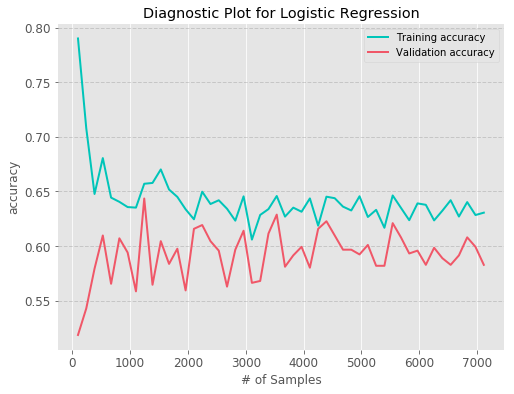

In [73]:
# call the function to calculate the scores
df_score_val, df_score_train = get_score(LR,
                                         X_res_norm,
                                         y_res,
                                         X_val_norm,
                                         y_val,
                                         np.linspace(100,X_res_norm.shape[0],50).astype(int))
print(df_score_train.tail())
print(df_score_val.tail())

# plot the result
plot_score("Diagnostic Plot for Logistic Regression", "accuracy", df_score_train, df_score_val)

### SVM with RBF kernel
Having inferred that the dataset is not linearly separable, the next attempt is to try a non-linear classifier. The following code shows the result of building the model with Support Vector Machine with RBF kernel function.

In [74]:
from sklearn.svm import SVC

SVM = SVC(C=50,
          kernel='rbf',
          gamma='auto',
          shrinking=True,
          tol=0.001,
          cache_size=200,
          verbose=0,
          max_iter=-1,
          decision_function_shape='ovr',
          random_state=15688)

SVM.fit(X_res_norm, y_res)
print("The training accuracy:", SVM.score(X_res_norm, y_res))
print("The validation accuracy:", SVM.score(X_val_norm, y_val))

The training accuracy: 0.877143660388
The validation accuracy: 0.647007805724


This time the result is more interesting that we are able to achieve high accuracy on the training set, but fail to get a satisfactory validation accuracy. Our model overfits the training data but tuning the hyperparameters does not help a lot. Overall, our model suffers from high variance. We can either get more data or adjust the model complexity to combat this problem.

Plotting the accuracy with the number of samples can be useful, in that, we can have a rough idea if getting more data will help. (and if so, how many more should we get?). In the chart, we can see that the validation accuracy plateau at the end. We can infer that, even if more data help enhance the model performance, the number of data probably needs to grow on a logarithmic scale. This would not be practical given the nature of how the data is generated. (Billboard TOP 100 only produces 100 data point at most per week)

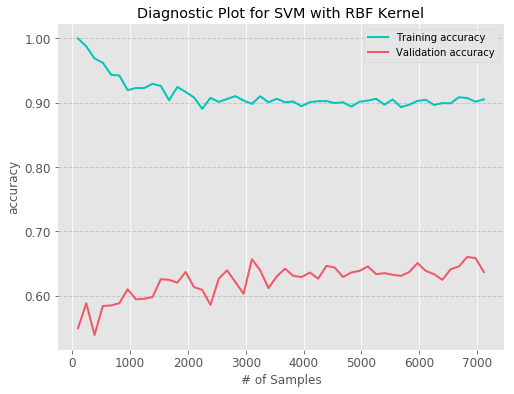

In [75]:
df_score_val, df_score_train = get_score(SVM,
                                         X_res_norm,
                                         y_res,
                                         X_val_norm,
                                         y_val,
                                         np.linspace(100,X_res_norm.shape[0],50).astype(int))
plot_score("Diagnostic Plot for SVM with RBF Kernel", "accuracy", df_score_train, df_score_val)

### Random Forest

#### The model
Our last attempt is to build the model with Random Forest. By averaging the results from some fully grown Decision Trees, we can lower the variance from the individual trees and hope that we get a low bias low variance forest as a whole.

In [76]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100,
                            criterion="entropy",
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features='auto',
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=1,
                            random_state=None,
                            verbose=0,
                            warm_start=False,
                            class_weight=None)
RF.fit(X_res_norm, y_res)
print("The training accuracy:", RF.score(X_res_norm, y_res))
print("The validation accuracy:", RF.score(X_val_norm, y_val))

The training accuracy: 1.0
The validation accuracy: 0.760624457936


In the following plot, we can see that the validation accuracy is still roughly rising with the higher sample size. This shows that more (but not incredibly more) data can help our model achieve better performance.

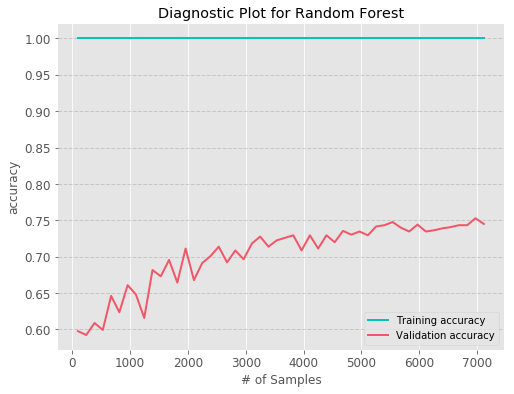

In [77]:
df_score_val, df_score_train = get_score(RF,
                                         X_res_norm,
                                         y_res,
                                         X_val_norm,
                                         y_val,
                                         np.linspace(100,X_res_norm.shape[0],50).astype(int))
plot_score("Diagnostic Plot for Random Forest", "accuracy", df_score_train, df_score_val)

Overall, Random Forest is giving us the best result (in terms of accuracy) and shows potential for further studies. We decide to fine-tune the hyperparameter and find the optimal tree size for our dataset is around 250.  The validation accuracy plateau afterwards.

In [83]:
############################  WITH RANK ######################################
# load to pickle
import pickle
with open("data/train_val_test_oversample_normalize_rank.pkl", "rb") as file:
    info_1, X_res_norm, X_val_norm, X_test_norm, y_res, y_val, y_test, X_res_mean, X_res_std = pickle.load(file)

with open("data/df_feature_label_audio_dummy_rank.pkl", "rb") as file:
    info2, df_label, df_feature = pickle.load(file)
############################  WITH RANK ######################################

X_train = np.append(X_res_norm, X_val_norm, axis = 0)
y_train = np.append(y_res, y_val, axis = 0)

# search from 10 to 6250 trees
np.geomspace(10, 6250, num=5).astype('int')

from sklearn.model_selection import GridSearchCV
# n_estimators = np.geomspace(10, 6250, num=5, dtype=int)
n_estimators = 2*np.logspace(1, 5, num=5, base = 5, dtype = 'int')
parameters = {'n_estimators':n_estimators}
rf = RandomForestClassifier(random_state=15688)
clf = GridSearchCV(rf, param_grid = parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=15688, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  10,   50,  250, 1250, 6250])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

best_params: {'n_estimators': 6250}
best_score: 0.91423732914


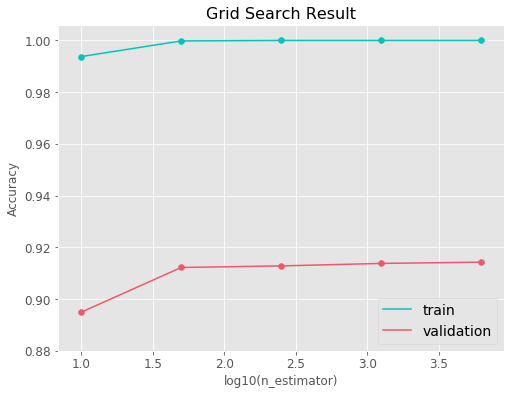

In [90]:
# plot the results
result = clf.cv_results_
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(np.log10(n_estimators), result['mean_test_score'], color = "#f05768")
plt.scatter(np.log10(n_estimators), result['mean_train_score'], color = "#00c5b9")
plt.plot(np.log10(n_estimators), result['mean_train_score'], label = 'train', color = "#00c5b9")
plt.plot(np.log10(n_estimators), result['mean_test_score'], label = 'validation', color = "#f05768")
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Accuracy')
plt.xlabel('log10(n_estimator)')
plt.title('Grid Search Result', fontsize = 16)
plt.plot()
          
# print the best parameters
print('best_params:', clf.best_params_)
print('best_score:', clf.best_score_)

#### Feature Importance
The scikit-learn package provides a convenient feature importance measurement using mean decrease impurity. The intuition is to measure a feature's importance by looking at the total decrease in node impurity after accounting for the probability of reaching that node (and averaging over all the trees in the forest).

An interesting finding is that the feature importance somehow matched what we have found in the EDA process, where speachiness and tempo are important for differentiating Super Hits from Hits. Also, the feature we created from the Feature Engineering section also has high importance.

In [85]:
RF_best = RandomForestClassifier(n_estimators=250,
                                 criterion="entropy",
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_features='auto',
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 bootstrap=True,
                                 oob_score=False,
                                 n_jobs=1,
                                 random_state=None,
                                 verbose=0,
                                 warm_start=False,
                                 class_weight=None)
RF_best.fit(X_res_norm, y_res)
print("The training accuracy:", RF.score(X_res_norm, y_res))
print("The validation accuracy:", RF.score(X_val_norm, y_val))

The training accuracy: 0.964576890638
The validation accuracy: 0.74501300954


[]

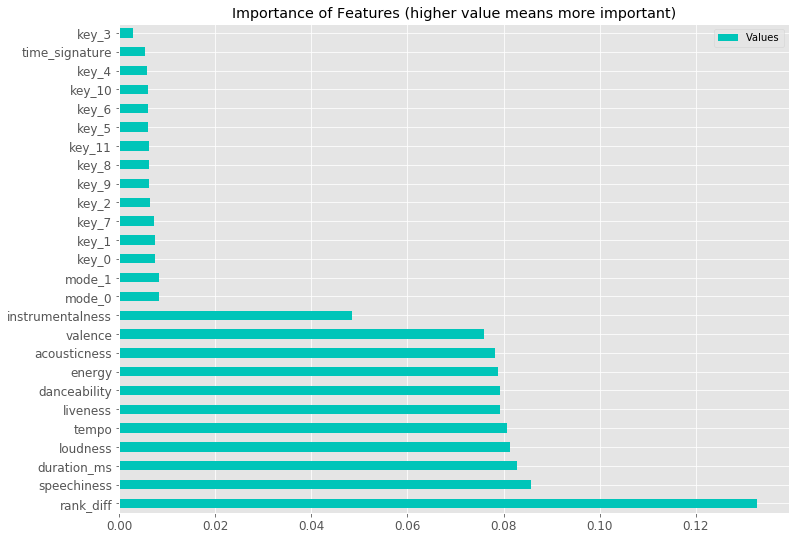

In [126]:
importances=RF_best.feature_importances_
impt_idx = np.argsort(-importances)
impt_values = importances[::-1]
impt_features = np.array(list(df_feature))[impt_idx]
df_impt = pd.DataFrame({"Features":list(df_feature), "Values":importances})
ax = df_impt.sort_values("Values", ascending=False)[['Features','Values']].plot.barh(color = "#00c5b9", figsize=(12,9), fontsize=12)
ax.set_yticklabels(df_impt.sort_values("Values", ascending=False).Features)
plt.title("Importance of Features (higher value means more important)")
plt.plot()

## Model Performance and Conclusion

### The Baseline
The baseline we choose to report with our model performance has the following predicting rule: If a rank of a song is rising in the first month, predict it as Super Hit. Otherwise, predict it as Hit.

The following code reports the baseline with our model performances.

In [134]:
############################  load data from pickles ######################################
# load to pickle
import pickle
with open("data/train_val_test_oversample_normalize_rank.pkl", "rb") as file:
    info_1, X_res_norm, X_val_norm, X_test_norm, y_res, y_val, y_test, X_res_mean, X_res_std = pickle.load(file)

with open("data/df_feature_label_audio_dummy_rank.pkl", "rb") as file:
    info2, df_label, df_feature = pickle.load(file)
############################  load data from pickles ######################################

# calculating the scores for baseline
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
super_hit = Counter(df_label)
pred_baseline = np.where(X_test_norm[:, 11] < 0, 1, 0)
df_feature["pred_superhit"] = np.where(df_feature["rank_diff"] < 0, 1, 0)

tp = 0
tn = 0
fp = 0
fn = 0

for pre, true in zip(pred_baseline, y_test):
    if pre == 1 and true == 1:
        tp += 1
    elif (pre == 1 and true == 0):
        fp += 1
    elif (pre == 0 and true == 1):
        fn += 1
    elif (pre == 0 and true == 0):
        tn += 1
        
accuracy_base = (tp+tn)/(tp+tn+fp+fn)
precision_base = (tp)/(tp+fp)
recall_base = (tp)/(tp+fn)
f1_base = 2 * (precision_base * recall_base) / (precision_base + recall_base)
        
# save the result in a dataframe
models = [LR, SVM, RF]
model_name = ['Logistic Regression', 'SVM(rbf)' , "Random Forest"]
df_perform = pd.DataFrame(index=model_name, columns=["accuracy","precision","recall","f1"])
df_perform.loc['Baseline'] = [accuracy_base, precision_base, recall_base, f1_base]

# calculating the scores for models
for name,  model in zip(model_name, models):
    df_score_test, df_score_train = get_score(model,X_res_norm,y_res,X_test_norm,y_test, n_samples = [X_res_norm.shape[0]])
    df_perform.loc[name, :] = list(df_score_test.iloc[:, 1:].values[0])

display(df_perform)

,accuracy,precision,recall,f1
Logistic Regression,0.618585,0.317881,0.581818,0.411135
SVM(rbf),0.633148,0.309021,0.487879,0.378378
Random Forest,0.757282,0.454955,0.306061,0.365942
Baseline,0.617198,0.320968,0.603030,0.418947


### Conclusion
In this project, we aim to build a classifier to predict the Super Hit songs (Songs that stay more than 20 weeks on the board) on Billboard. We went through the entire Data Science pipeline, from Data Collecting, Data Processing, Feature Engineering, to Model Building and Testing.

From the EDA process, we discovered that there are trends in audio features, in terms of duration and loudness, for both Hits and Super Hits. We also found that speachiness and rank soaring speed in the first month are important features to differentiate Super Hits from Hits. From the information distilled from the EDA process, and the insight from the Data Science debugging process, we built a decent model that has accuracy over 75%, and shown that our model has potential to do better with more data.

## References

Basterra, L., Fowler, B., Rajendiran, M., & Rushin, G. (n.d.).<br/>Started from the Bottom Now We Here: Predicting the Top Releases in the Billboard Hot 100 Charts. Retrieved from https://github.com/dbfowler/predicting_billboard_hits/blob/master/Output/LinearModelsReport.pdf

Fowler, B. (2017, January 8). Billboard Volatility : How Have The Charts Changed? Retrieved from<br/> http://decibelsanddecimals.com/dbdblog/2017/1/8/billboard-volatility.html

Lemaître, G., Nogueira, F., & Aridas, C. K. (2017). Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning. Journal of Machine Learning Research,18, 1-5. <br/>Retrieved from http://jmlr.org/papers/v18/16-365.html

Trust, G. (2015, November 23). Adele Tops Hot 100 for Fourth Week; Justin Bieber, Alessia Cara Hit Top 10. <br/>Retrieved from https://www.billboard.com/articles/columns/chart-beat/6770427/adele-tops-hot-100-fourth-week-justin-bieber-alessia-cara

## Appendix

In this section, we provide the code for how we scraped the rank of the songs from Billboard and based on which, how we acquired the audio features for each song from Spotify. The goal was to collect the artist name, song name and audio features (tempo, loudness, danceability etc.) for further analysis.

Billboard had been providing Spotify ID along with the artist name and song name on the HIT 100 music leaderboard until late 2017. After late 2017, the Spotify ID was taken off the board. As a result, we have to make queries to the Spotify Web API with the artist name and song name to get the audio features of a song. Some data are lost during the matching process for mainly two reason:
1. Some data are lost because of the inconsistency between how Billboard and Spotify record their data. We cannot manually match the differences.
2. Not every song Billboard can be found on Spotify. This is mainly due to business decisions. For example, albums from Beyonce and JAY Z are largely in absence.

Below are the code if they are of interest:

### Billboard

In [ ]:
# scrape billboard using the package "billboard" created by guoguo12
# !pip install billboard.py
# https://github.com/guoguo12/billboard-charts
import billboard
charts = []
chart = billboard.ChartData('hot-100',date="2018-04-21") #begin date
while chart.previousDate:
    if chart.previousDate=="1989-12-30": #end datte
        break
    chart = billboard.ChartData('hot-100', chart.previousDate)
    charts.append(chart)
    
# store the data in a dataframe and save in a csv
import pandas as pd
allRecords=pd.DataFrame(columns=['rank','song_name','singer','date','weeks'])

for chart in charts:
    for i in range(len(chart)):
        row=[]
        artist = chart[i].artist
        if "&" in artist:
            artist=artist.split(" & ")[0]
        if "Featuring" in artist:
            artist=artist.split(" Featuring ")[0]
        if "X" in artist:
            artist=artist.split(" X ")[0]
        if "x" in artist:
            artist=artist.split(" x ")[0]
        if "," in artist:
            artist=artist.split(", ")[0]
        row = pd.Series({'rank':i+1, 'song_name':chart[i].title, 'singer':artist, 'date':str(chart)[18:29],'weeks':chart[i].weeks})
        allRecords=allRecords.append(row,ignore_index=True)

#     allRecords.to_csv("data/billboard_19902018.csv", encoding='utf-8', index = False)

### Get SpotifyId
Use song name and singer to search for spotifyId using Spotify API

In [ ]:
import numpy as np
import pandas as pd
import time
import spotipy
import requests
import json
from  spotipy import util
from spotipy.oauth2 import SpotifyClientCredentials

with open ("Spotify_Client_ID.txt") as f:
    spotify_key = f.read().split()
spotify_id = spotify_key[0]
spotify_secret = spotify_key[1]

In [ ]:
rankings = pd.read_csv("rankingcsvs/billboard_19902018.csv")
track_artist = rankings[['song_name', 'singer']].drop_duplicates().values

In [ ]:
spotifyId = []
trackName = []
releaseDate = []
popularity = []
artists_name = []
artists_id = []
track_number = []
b_artist = []
b_trackName = []
album_id = []

failed_search = {}

In [ ]:
import string
def process(word):
    word = word.lower().replace(" ", "")
    word = (''.join(x if x not in string.punctuation else '' for x in word)).strip()
    return word

In [ ]:
%%time
current = time.localtime()
start_time = current.tm_hour*60 + current.tm_min

for idx, info in enumerate(track_artist):
    time.sleep(0.1)
    if idx%5000 == 0:
        print('Current index', idx)
        print(time.localtime().tm_hour, ':', time.localtime().tm_min)
        grant_type = 'client_credentials'
        body_params = {'grant_type' : grant_type}
        client_id = spotify_id
        client_secret = spotify_secret
        url='https://accounts.spotify.com/api/token'
        response=requests.post(url, data=body_params, auth = (client_id, client_secret)) 
        result = response.json()

        headers = {
            'Authorization': 'Bearer '+ result['access_token'],
        }
        print('******Token Renewed*******')
    
    
    try:
        query = 'q=artist:'+ info[1].lower()+'%20track:'+ info[0].lower() + '&type=track'
        result = requests.get("https://api.spotify.com/v1/search?" + query, headers=headers).json()
        flag = True
        for track in result['tracks']['items']:
            temp_name = []
            temp_id = []
            for artist_ls in track['artists']:
                temp_name.append(artist_ls['name'])
                temp_id.append(artist_ls['id'])
            if process(track['name']).startswith(process(info[0])) and any([process(i).find(process(info[1])) != -1 for i in temp_name]):
                spotifyId.append(track['id'])
                trackName.append(track['name'])
                releaseDate.append(track['album']['release_date'])
                popularity.append(track['popularity'])
                track_number.append(track['track_number'])
                album_id.append(track['album']['id'])
                artists_name.append(temp_name)
                artists_id.append(temp_id)
                b_artist.append(info[1])
                b_trackName.append(info[0])
                flag = False
                break
        if flag:
            print('Failed to search')
            print(idx)
            print(info)
            print()
            failed_search[idx] = info

    except:
        print('Failed to search')
        print(idx)
        print(info)
        print()
        failed_search[idx] = info

print('**************Search Ended******************')
print(time.localtime().tm_hour, ':', time.localtime().tm_min)  

In [ ]:
d = {'spotifyId': spotifyId,
     'trackName': trackName,
     'releaseDate': releaseDate,
     'popularity': popularity,
     'artists_name': artists_name,
     'artists_id': artists_id, 
     'track_number': track_number,
     'b_trackName': b_trackName,
     'b_artist': b_artist, 
     'album_id': album_id
    }
Billboard_19902018 = pd.DataFrame(data=d)

In [ ]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

def drop_duplicate(df):
    df['similarity'] = df.apply(lambda row: similar(row.b_trackName.lower(), row.trackName), axis=1)
    df_test = df.sort_values(by = 'similarity').drop_duplicates(subset = 'spotifyId', keep = 'last')
    return df_test

In [ ]:
# Deal with duplicates
Billboard_19902018 = drop_duplicate(Billboard_19902018)
# Billboard_19902018.to_csv('data/19902018_mid.csv', index = False)

### Search for Audio Features

In [ ]:
acousticness = []
analysis_url = []
danceability = []
duration_ms = []
energy = []
spotifyId = []
instrumentalness = []
key = []
liveness = []
loudness = []
mode = []
speechiness = []
tempo = []
time_signature = []
valence = []

In [ ]:
d = {
"acousticness":acousticness,
"analysis_url":analysis_url,
"danceability":danceability,
"duration_ms":duration_ms,
"energy":energy,
"spotifyId":spotifyId,
"instrumentalness":instrumentalness,
"key":key,
"liveness":liveness,
"loudness":loudness,
"mode":mode,
"speechiness":speechiness,
"tempo":tempo,
"time_signature":time_signature,
"valence":valence
}

In [ ]:
loop_num = len(Billboard_19902018["spotifyId"])//100
ex_cutpoint = 0
failed_search = []
for i in range(1,loop_num+1):
    try:
        current_cutpoint = i*100
        id_list = Billboard_19902018["spotifyId"].tolist()[ex_cutpoint:current_cutpoint]
        ids="ids="+",".join(id_list)
        result = requests.get("https://api.spotify.com/v1/audio-features/?"+ids, headers=headers).json()
        time.sleep(1.5)
        i = 0
        for key in d.keys():
            i+=1
            if key=="spotifyId":
                d["spotifyId"].extend(track["id"] for track in result["audio_features"])
            else:
                d[key].extend(track[key] for track in result["audio_features"])
        ex_cutpoint = current_cutpoint
        print("Success", current_cutpoint)
    except:
        print('Fail: ', ex_cutpoint, 'to', current_cutpoint)
        failed_search.append((ex_cutpoint, current_cutpoint))
        for key in d.keys():
            d[key] = d[key][:ex_cutpoint]
        ex_cutpoint = current_cutpoint


In [ ]:
last_cutpoint = len(Billboard_19902018["spotifyId"])%100
ex_cutpoint = 0
id_list = Billboard_19902018["spotifyId"].tolist()[-last_cutpoint:]
ids="ids="+",".join(id_list)
result = requests.get("https://api.spotify.com/v1/audio-features/?"+ids, headers=headers).json()
time.sleep(1.5)
i = 0
for key in d.keys():
    i+=1
    if key=="spotifyId":
        d["spotifyId"].extend(track["id"] for track in result["audio_features"])
    else:
        d[key].extend(track[key] for track in result["audio_features"])
print("Success", last_cutpoint, "to the end")

In [ ]:
failed_id = []
ex, cur = failed_search[0]
for idx in Billboard_19902018["spotifyId"][ex:cur]:
    try:
        result = requests.get("https://api.spotify.com/v1/audio-features/"+idx, headers=headers).json()
        time.sleep(1.5)
        for key in d.keys():
            if key=="spotifyId":
                d["spotifyId"].append(result["id"])
            else:
                d[key].append(result[key])
    except:
        print('Fail: ', idx)
        failed_id.append(idx)

In [ ]:
df = pd.DataFrame(d)
Billboard_audio_feature = Billboard_19902018.merge(df, on = 'spotifyId', how = 'inner')
# Billboard_audio_feature.to_csv("data/19902018_Billboard_audio_feature.csv", index = False)